In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from datetime import date
from datetime import timedelta

from yahoofinancials import YahooFinancials

from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

import warnings
warnings.filterwarnings('ignore')

In [2]:
end = '2021-08-11'
start = '2016-07-20'

In [3]:
stock_symbol = 'TCS.NS'

yf = YahooFinancials(stock_symbol)
data = yf.get_historical_price_data(start, end, 'daily')
TCS = pd.DataFrame(data['TCS.NS']['prices'])
TCS = TCS.drop('date', axis=1).set_index('formatted_date')

TCS['Date'] = pd.to_datetime(TCS.index, format="%Y-%m-%d")
TCS.set_index('Date', drop=False, inplace=True)

df = TCS.dropna()

In [4]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']
df.head()

,high,low,open,close,volume,adjclose,Date
Date,,,,,,,
2016-07-20,1251.250000,1224.074951,1225.000000,1247.474976,2815252.0,1129.042114,2016-07-20
2016-07-21,1259.750000,1232.224976,1244.750000,1253.025024,2527148.0,1134.065430,2016-07-21
2016-07-22,1262.000000,1246.000000,1249.449951,1257.550049,1517216.0,1138.160645,2016-07-22
2016-07-25,1281.599976,1252.900024,1256.000000,1279.474976,1688796.0,1161.004517,2016-07-25
2016-07-26,1284.000000,1266.500000,1279.474976,1276.300049,2311290.0,1158.123901,2016-07-26


In [5]:
df.shape

(1247, 7)

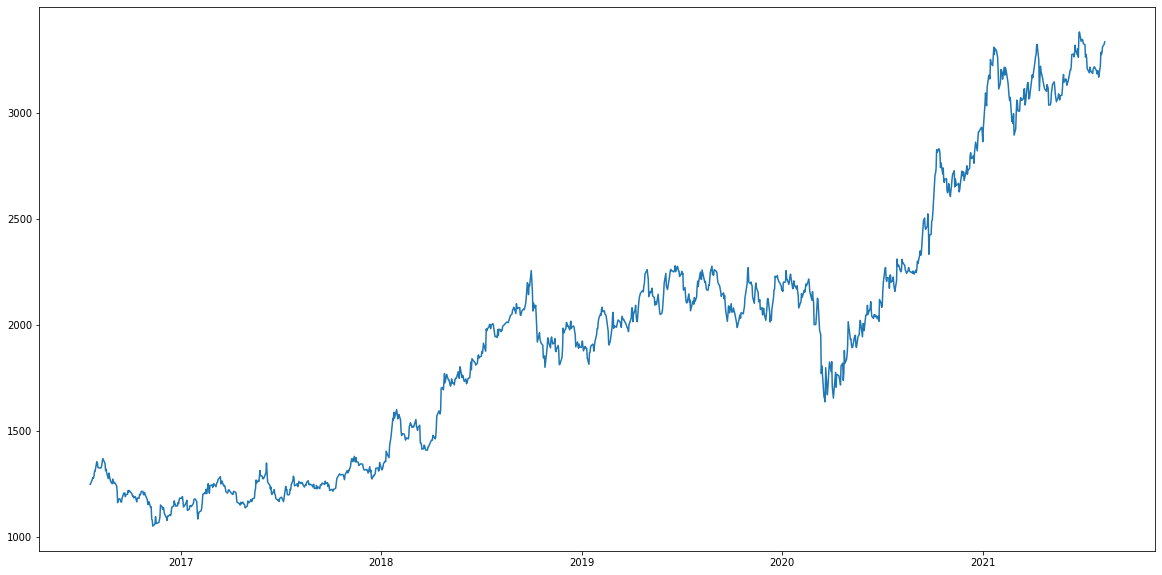

In [6]:
plt.plot(df['close'])

In [7]:
data = df.sort_index(ascending=True, axis=0)

In [8]:
FullData = data[['close']].values

sc = MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X = DataScaler.transform(FullData)

In [9]:
X = X.reshape(X.shape[0],) 

In [10]:
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps = 60   # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps = 30 # How many days in future you want to predict the prices
 
# Iterate through the values to create combinations
for i in range(TimeSteps, NumerOfRows-FutureTimeSteps):
    
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data = np.array(X_samples)
X_data = X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)

In [11]:
X_data.shape

(1157, 60, 1)

In [12]:
trl = len(X_data) - FutureTimeSteps

In [13]:
# Splitting the data into train and test
X_train = X_data[:trl]
X_test = X_data[trl:]

y_train = y_data[:trl]
y_test = y_data[trl:]

In [14]:
TimeSteps = X_train.shape[1]
TotalFeatures = X_train.shape[2]

In [15]:
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 50, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 

# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 25, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 25, activation = 'relu', return_sequences=False ))
 

# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

In [16]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
36/36 [==============================] - 9s 101ms/step - loss: 0.1658
Epoch 2/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0451
Epoch 3/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0100
Epoch 4/100
36/36 [==============================] - 3s 95ms/step - loss: 0.0051
Epoch 5/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0051
Epoch 6/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0052
Epoch 7/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0041
Epoch 8/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0043
Epoch 9/100
36/36 [==============================] - 3s 97ms/step - loss: 0.0037
Epoch 10/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0036
Epoch 11/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0036
Epoch 12/100
36/36 [==============================] - 3s 97ms/step - loss: 0.0033
Epoch 13/100
36/36 [====

36/36 [==============================] - 3s 95ms/step - loss: 0.0019:


In [18]:
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig = y_test
orig = DataScaler.inverse_transform(y_test) 

In [19]:
from sklearn.metrics import mean_squared_error

mean_squared_error(orig, predicted_Price)

17062.078153957533

In [20]:
Last10DaysPrices = FullData[-TimeSteps:]
 
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

array([[3136.058 , 3146.4146, 3142.7795, 3139.4143, 3130.613 , 3144.7466,
        3162.3904, 3132.7607, 3163.976 , 3176.629 , 3154.3335, 3169.824 ,
        3155.4834, 3196.641 , 3182.032 , 3193.9658, 3187.9336, 3191.9067,
        3193.0767, 3185.3967, 3197.3413, 3214.9202, 3194.2383, 3205.9167,
        3217.2937, 3209.5283, 3201.1074, 3234.967 , 3230.7214, 3238.3035]],
      dtype=float32)

In [21]:
Next5DaysPrice = Next5DaysPrice.reshape((-1, 1))

In [22]:
def predict_dates(num_prediction):
    last_date = end
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [23]:
forecast_dates = predict_dates(FutureTimeSteps-1)

In [24]:
fd = pd.DataFrame(Next5DaysPrice, index=forecast_dates)

In [25]:
fd

,0
2021-08-11,3136.058105
2021-08-12,3146.414551
2021-08-13,3142.779541
2021-08-14,3139.414307
2021-08-15,3130.613037
2021-08-16,3144.746582
2021-08-17,3162.390381
2021-08-18,3132.760742
2021-08-19,3163.976074
2021-08-20,3176.628906


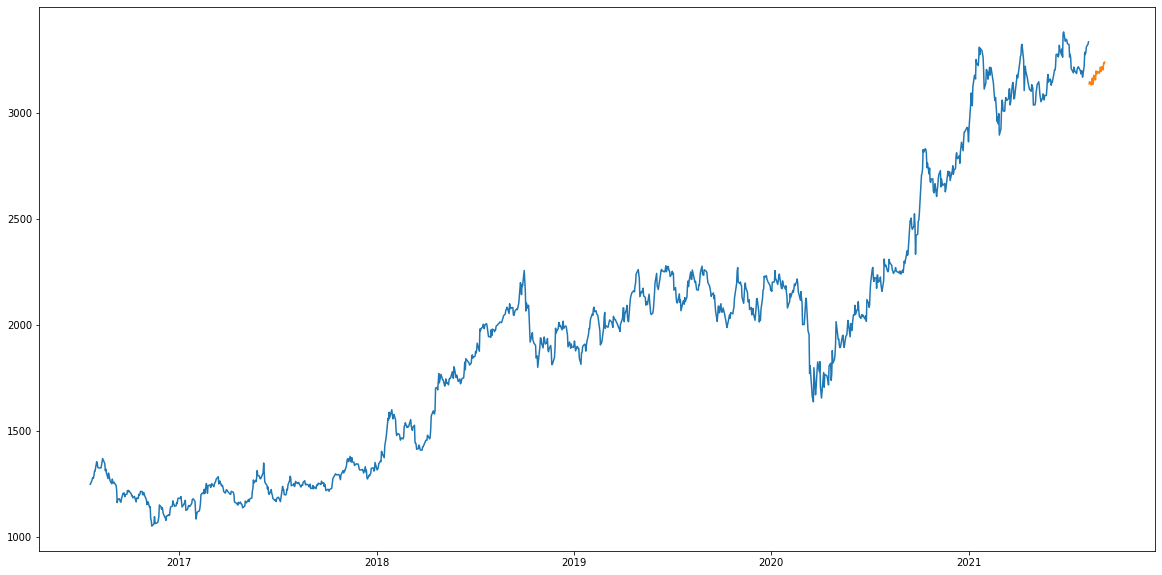

In [26]:
plt.plot(df['close'])
plt.plot(fd)

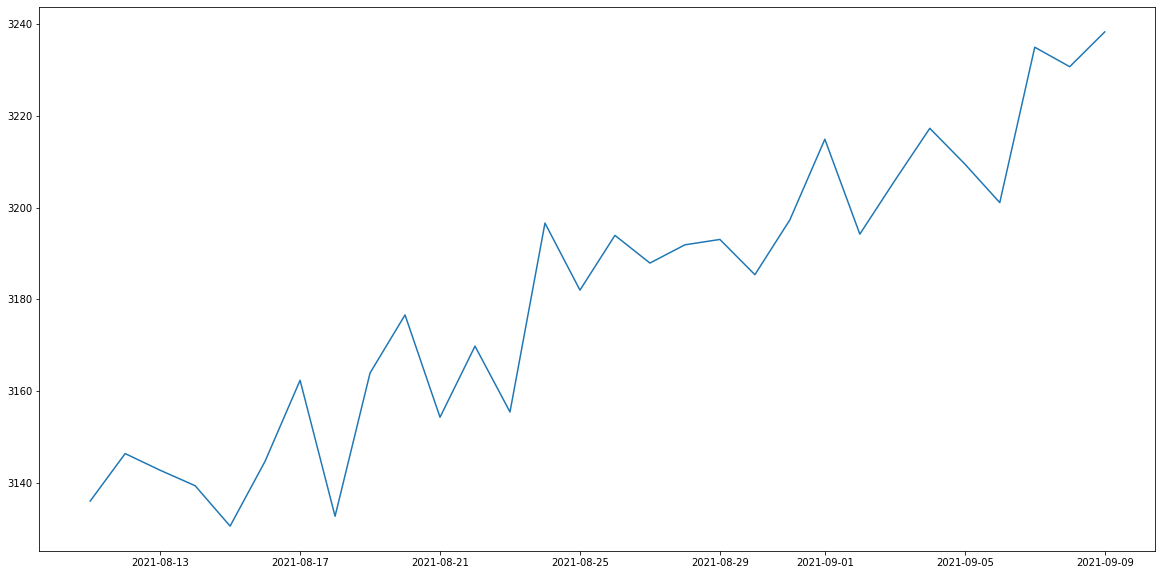

In [27]:
plt.plot(fd)